# Gradient Boosting

The next classification model we will investigate is the Gradient Boosting Classifier.

## Importing the libraries

In [88]:
## REQUIRED LIBRARIES
# For data wrangling 
import numpy as np
import pandas as pd


# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# For creating the model
from sklearn.ensemble import GradientBoostingClassifier

#For evaluating the model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, balanced_accuracy_score

In [89]:
import pickle

#Loading the training and test splits from the pickle file
with open('../data/train_test_data.pickle', 'rb') as file:
    train_test_split = pickle.load(file)

X_train_raw = train_test_split['X_train_raw']
y_train_raw = train_test_split['y_train_raw']
X_test_raw = train_test_split['X_test_raw']
y_test_raw = train_test_split['y_test_raw']

## Importing the splits

In [90]:
with open('../data/train_splits.pickle', 'rb') as file:
    split_data = pickle.load(file)

In [91]:
split_data.keys()

dict_keys(['random', 'stratified', 'undersample', 'oversample'])

## Initial Model

Here, we'll create an initial classification model using the GradientBoostingClassifier function from scikit-learn and test it on our splits.

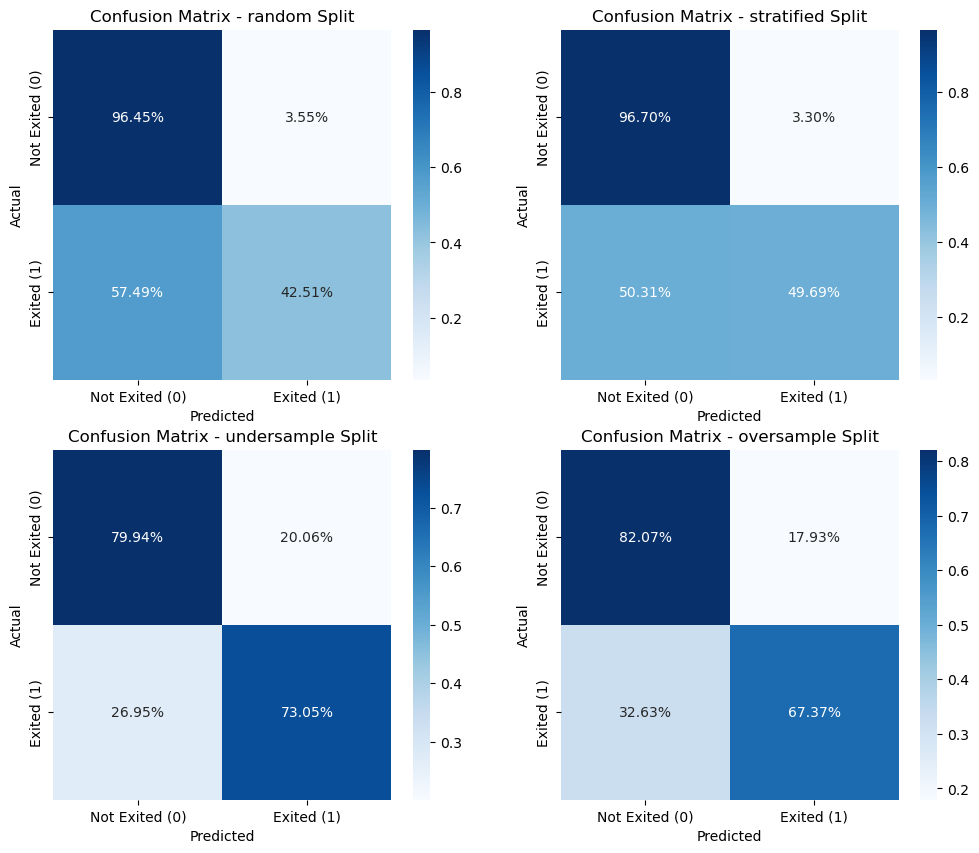

<Figure size 800x600 with 0 Axes>

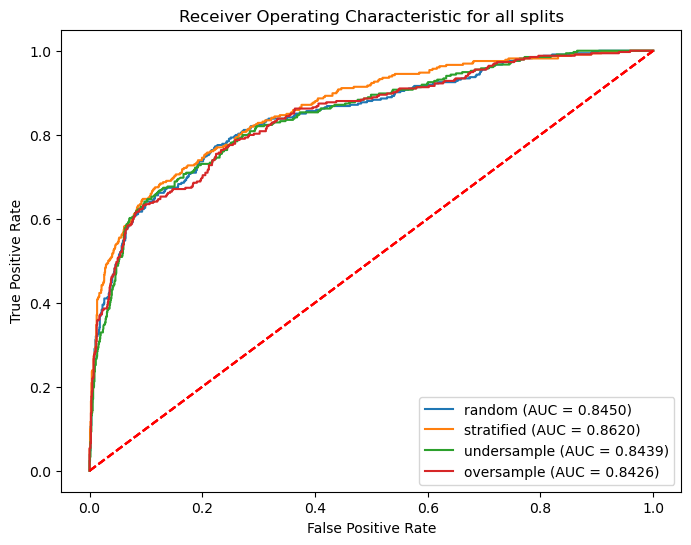

In [92]:
#We now need to create our Gradient Boosting Classification model

model = GradientBoostingClassifier(random_state=0)

#Create somewhere to store the performance metrics
performance ={}

def evaluating_performance_diff_splits(model=model,split_data=split_data,performance_matrix=performance):

    #Creating 2x2 grid for confusion matrices
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    plt.figure(figsize=(8,6))

    #ROC Curve Figure
    plt.figure(figsize=(8,6))

    #Fit model for each of the 4 splits
    for idx, split in enumerate(split_data):

        X_train, X_val, y_train, y_val =split_data[split]
    
        #Train model
        model.fit(X_train, y_train)

        y_score = model.predict_proba(X_val)[:, 1]
    
        #Predict on validation set
        y_val_pred = model.predict(X_val)

        #Plot confusion matrix for test set
        conf_matrix = confusion_matrix(y_val, y_val_pred)
        tn, fp, fn, tp = conf_matrix.ravel()

        #Normalize the confusion matrix by the number of true samples per class to get the values of the confusion matrix as a percentage of the total and labelling
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[idx],
                    xticklabels=['Not Exited (0)', 'Exited (1)'],
                    yticklabels=['Not Exited (0)', 'Exited (1)'])
        axes[idx].set_title(f'Confusion Matrix - {split} Split')
        axes[idx].set_ylabel('Actual')
        axes[idx].set_xlabel('Predicted')

    
        #Plot ROC curve on the same figure for all splits
        fpr, tpr, _ = roc_curve(y_val, y_score)
        roc_auc = roc_auc_score(y_val, y_score)
        plt.plot(fpr, tpr, label=f'{split} (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for all splits')
        plt.legend(loc="lower right")#

        #Get general classification report
        test_report = classification_report(y_val, y_val_pred, output_dict = True)

        #Balanced accuracy, precision, recall, and F1-score for class 1 (positive class)
        precision = test_report['1']['precision']
        recall = test_report['1']['recall']
        f1_score = test_report['1']['f1-score']
        balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
        
        #Define performance metrics
        performance_matrix[split] = {
            'test_precision_1': precision,
            'test_recall_1': recall,
            'test_f1_score_1': f1_score,
            'false_positives': fp,
            'false_negatives': fn,
            'balanced_accuracy': balanced_acc
        }

    #Show the plots
    plt.show()
    return performance_matrix  

performance = evaluating_performance_diff_splits(model=model,split_data=split_data,performance_matrix=performance)
    

We can see from the ROC curve that the model performs well on all splits, particularly on the oversample and undersample splits. This is to be expected due to the nature of the dataset we're considering as it is imbalanced and the over/undersampling accounts for this.

In the context of our problem, we're interested in getting a high Recall value from our models, since we want to make sure we identify the customers who are going to churn so that the bank can put retention methods in place. 

The effects of the imbalanced dataset can be seen when it comes to the Recall of the random and stratified splits. In both these cases, the make-up of the data in the validation and test sets is expected to be very similar to that of the full dataset. Therefore, when training our model it doesn't have much information to go off when it comes to the predicting those who will churn, since a significantly smaller number of those in our data do churn.

On the contrary, oversampling and undersampling generate balanced test sets and assist model performance leading to the improved performance we can see above. The Recall value in undersampling and oversampling are of a satisfactory level.

In terms of accuracy, the initial Gradient Boosting Classifier model outperforms the baseline on both fronts.

In the following, we'll attempt to refine and improve the model by adjusting the parameters.

In [93]:
performance_df = pd.DataFrame(performance).T

In [94]:
performance_df

,test_precision_1,test_recall_1,test_f1_score_1,false_positives,false_negatives,balanced_accuracy
random,0.759358,0.425150,0.545106,45.0,192.0,0.694802
stratified,0.794118,0.496933,0.611321,42.0,164.0,0.731983
undersample,0.489960,0.730539,0.586538,254.0,90.0,0.764954
oversample,0.497788,0.673653,0.572519,227.0,109.0,0.747174


## Parameter Tuning

For efficiency reasons, we will use Randomized Search Cross Validation in order to help optimise the parameters of our model. We prefer this to Grid Search Cross Validation as opposed to testing every combination of parameters, it randomly selects them and therefore runs in a fraction of the time.

We'll start by seeing what parameters are currently at play in our model.

In [46]:
#look at the parameters used by our gradient boosting classifier
print('Parameters currently in use:\n')
model.get_params()

Parameters currently in use:



{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

We then commence the randomised search to find better parameters.

In [47]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
f1_scorer = make_scorer(f1_score)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 4]
}

random_search = RandomizedSearchCV(model, param_grid, n_iter=100, cv=5, scoring=f1_scorer,random_state = 0)
random_search.fit(X_train_raw, y_train_raw)

print(f'Best Parameters: {random_search.best_params_}')


c:\Users\djjjo\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1}


We will now run a model with these parameters

{'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1} 0.5940452584904861


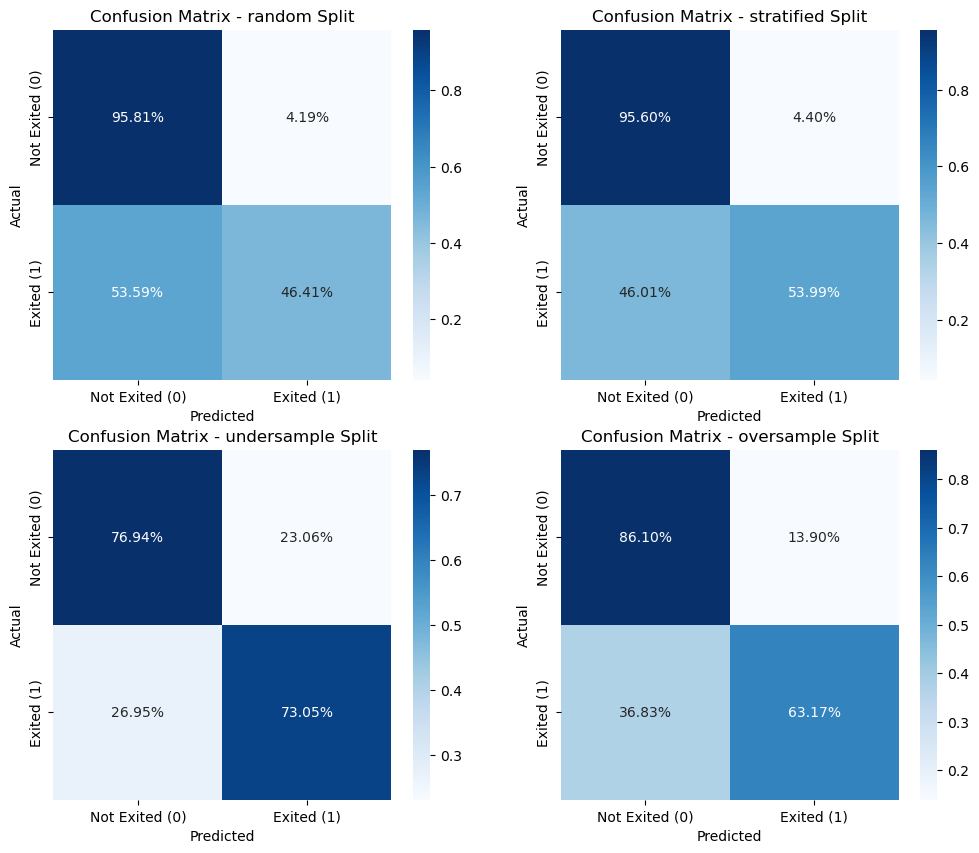

<Figure size 800x600 with 0 Axes>

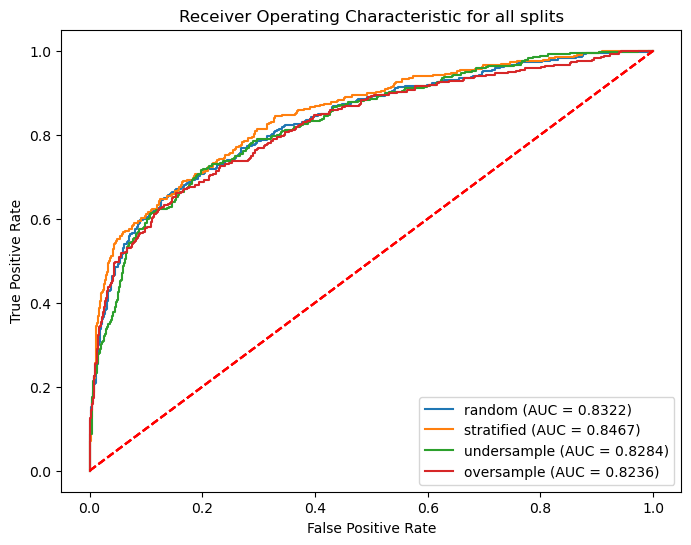

In [48]:
best_params = random_search.best_params_
best_score = random_search.best_score_
print(best_params, best_score)

best_model = GradientBoostingClassifier(**best_params,random_state=0)
performance_best = {}
performance_best = evaluating_performance_diff_splits(model=best_model,split_data=split_data,performance_matrix=performance_best)


In [49]:
best_performance_df = pd.DataFrame(performance_best).T
best_performance_df

,test_precision_1,test_recall_1,test_f1_score_1,false_positives,false_negatives,balanced_accuracy
random,0.745192,0.464072,0.571956,53.0,179.0,0.711104
stratified,0.758621,0.539877,0.630824,56.0,150.0,0.747961
undersample,0.455224,0.730539,0.560920,292.0,90.0,0.749946
oversample,0.545220,0.631737,0.585298,176.0,123.0,0.746358


This has made our model worse on all splits.

## Bagging

We will now combine another ensemble method with our Gradient Boosting Classifier. This is not common practice but it will help improve our model. For this we'll use the model we generated using the hyperparameter tuning.

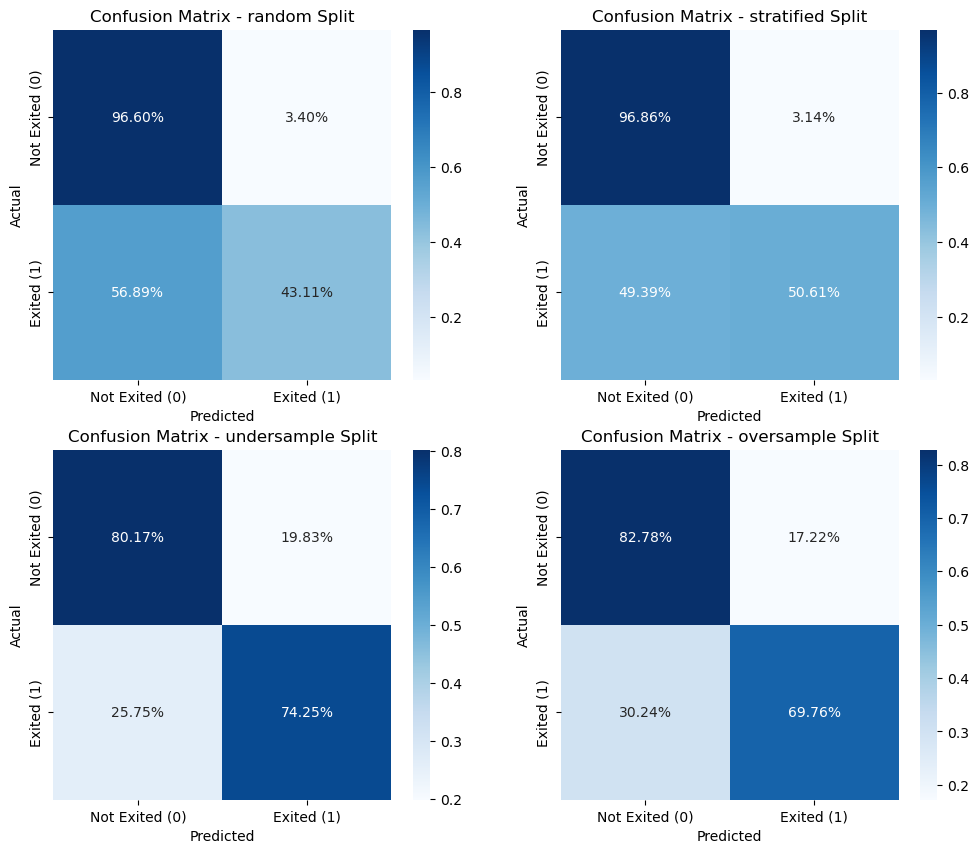

<Figure size 800x600 with 0 Axes>

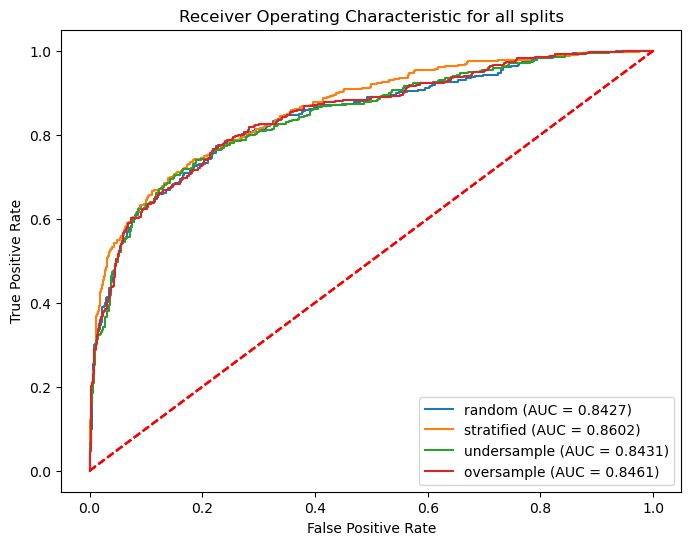

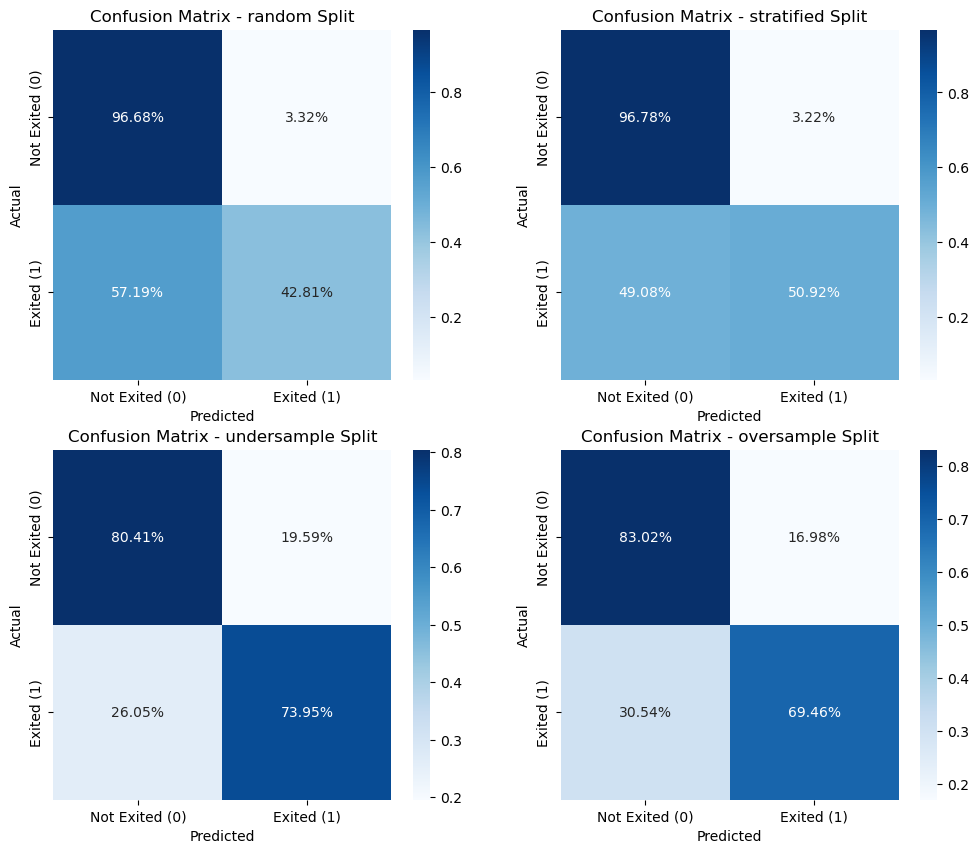

<Figure size 800x600 with 0 Axes>

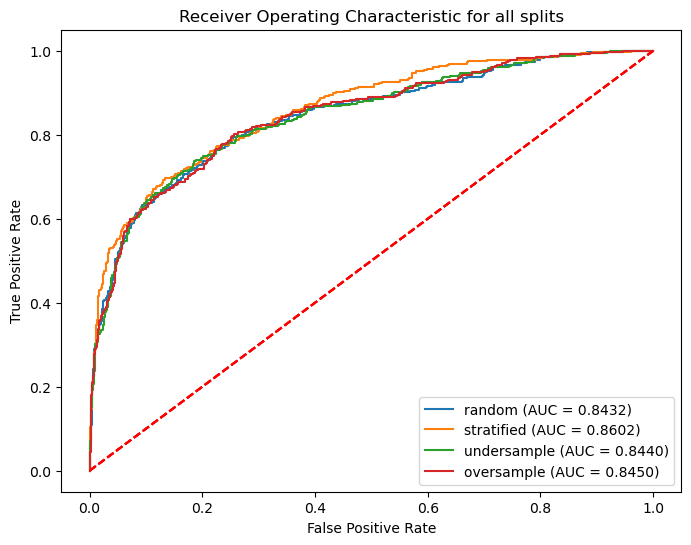

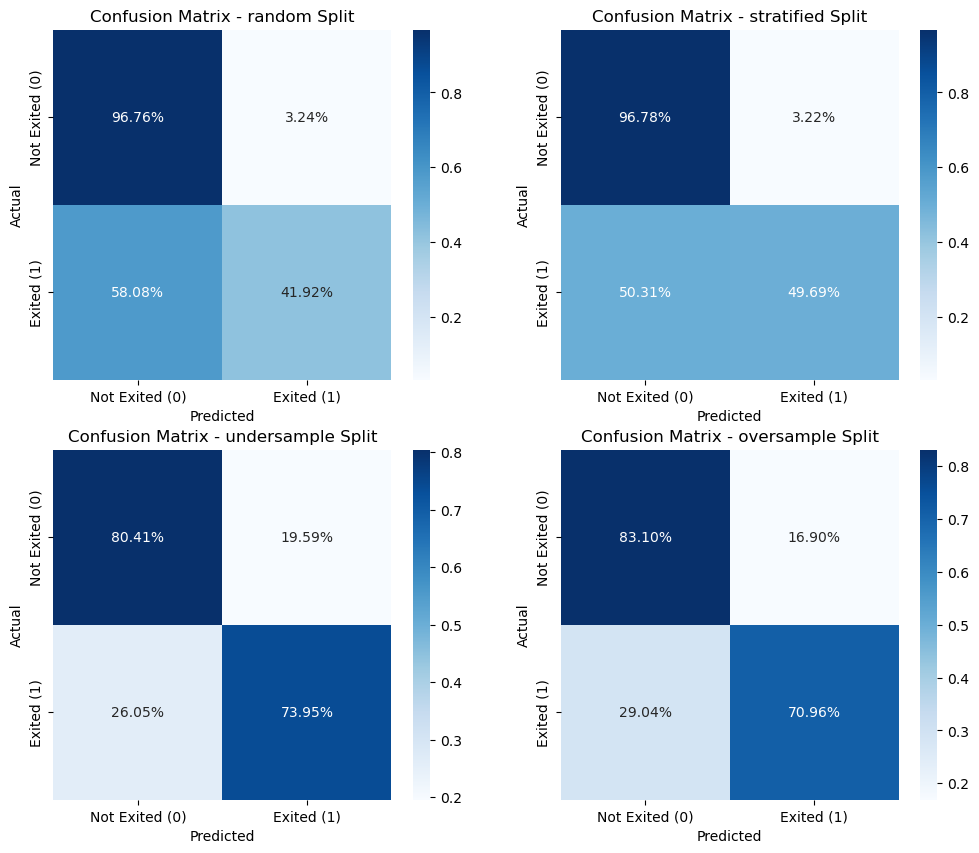

<Figure size 800x600 with 0 Axes>

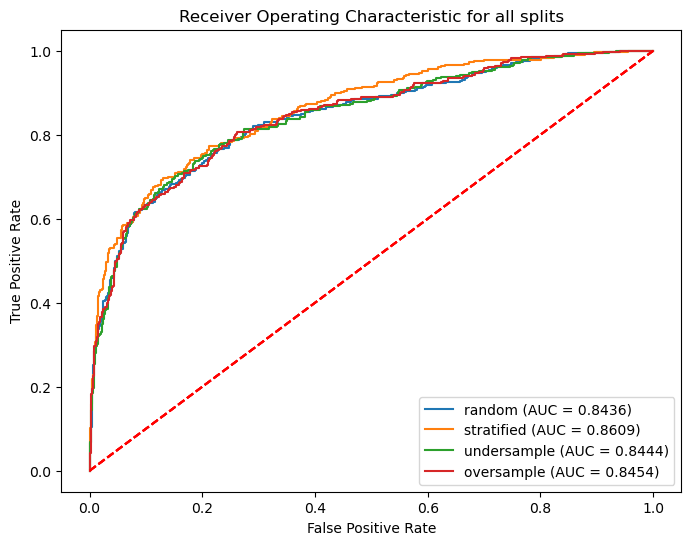

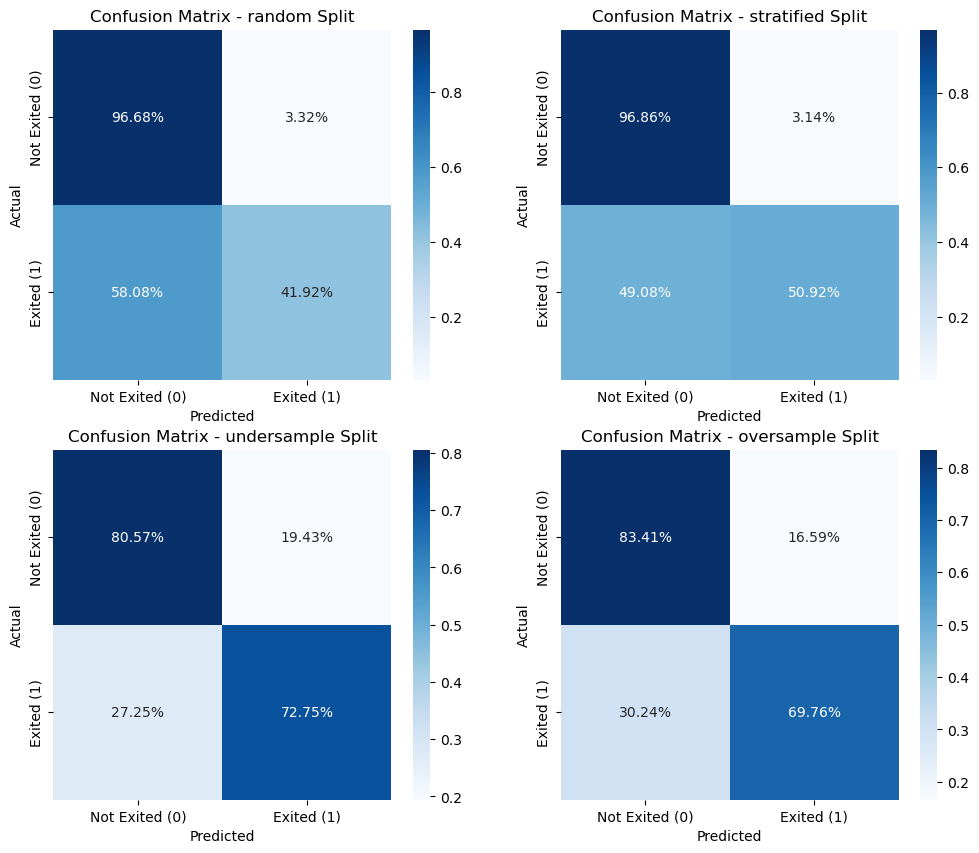

<Figure size 800x600 with 0 Axes>

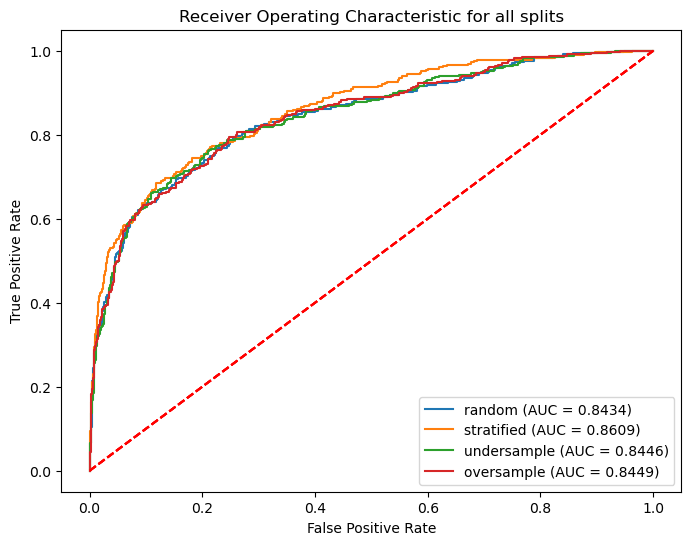

In [50]:
from sklearn.ensemble import BaggingClassifier

estimator_range = [8,12,16,20]

for i in estimator_range:
    bagging_model = BaggingClassifier(estimator=best_model, n_estimators = i, random_state = 0)

    bagging_model.fit(X_train_raw, y_train_raw)

    performance_bagging = {}
    performance_bagging = evaluating_performance_diff_splits(model=bagging_model,split_data=split_data,performance_matrix=performance_bagging)


We can see that with regards to recall value, our model has improved slightly for all splits bar the oversample split, with a peak seen with 12 estimators. But more can still be done to improve our model.

## Feature Removal

One area in which the Gradient Boosting Classifier suffers, similarly to the random forest seen earlier, is overfitting. The removal of certain variables in the data set can help remedy this and decrease the noise in the dataset, leading to improved performance on test sets, a more robust model, and greater generalisability.

We'll begin by seeing what variables are in the dataset.

In [95]:
X_train_rnd, X_val_rnd, y_train_rnd, y_val_rnd = split_data['random']

In [96]:
variables=list(X_train_rnd.columns)
print(variables)

['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'BalanceSalaryRatio', 'TenureByAge', 'CreditScoreGivenAge', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']


In [99]:
best_model.fit(X_train_rnd, y_train_rnd)
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': variables, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df


,Feature,Importance
1,Age,0.298692
3,NumOfProducts,0.207929
4,BalanceSalaryRatio,0.087157
2,Balance,0.084374
7,IsActiveMember,0.083366
6,CreditScoreGivenAge,0.067379
0,CreditScore,0.053758
9,Geography_Germany,0.052407
5,TenureByAge,0.045554
11,Gender_Female,0.007040


We can see that at a threshold of circa 0.05, gender and geography are important. In the context of our problem and using common sense, although Geography_Germany is above the 0.05 threshold we will remove this feature to remain consistent with removing the other two geographical variables.

In [100]:
importantvars = feature_importance_df.head(7)
print(importantvars)

               Feature  Importance
1                  Age    0.298692
3        NumOfProducts    0.207929
4   BalanceSalaryRatio    0.087157
2              Balance    0.084374
7       IsActiveMember    0.083366
6  CreditScoreGivenAge    0.067379
0          CreditScore    0.053758


In [102]:
importantvars_indices = [X_test_raw.columns.get_loc(feature) for feature in importantvars['Feature']]
print(importantvars_indices)

[1, 3, 4, 2, 7, 6, 0]


In [103]:
# Filter the splits to retain only the top 5 features
for split in split_data:
    X_train, X_val, y_train, y_val = split_data[split]
    split_data[split] = (
        X_train.iloc[:, importantvars_indices],
        X_val.iloc[:, importantvars_indices],
        y_train,
        y_val
    )

# Verify the changes
for split in split_data:
    X_train, X_val, y_train, y_val = split_data[split]
    print(f"{split} split - X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")

random split - X_train shape: (6400, 7), X_val shape: (1600, 7)
stratified split - X_train shape: (6400, 7), X_val shape: (1600, 7)
undersample split - X_train shape: (2594, 7), X_val shape: (1600, 7)
oversample split - X_train shape: (10206, 7), X_val shape: (1600, 7)


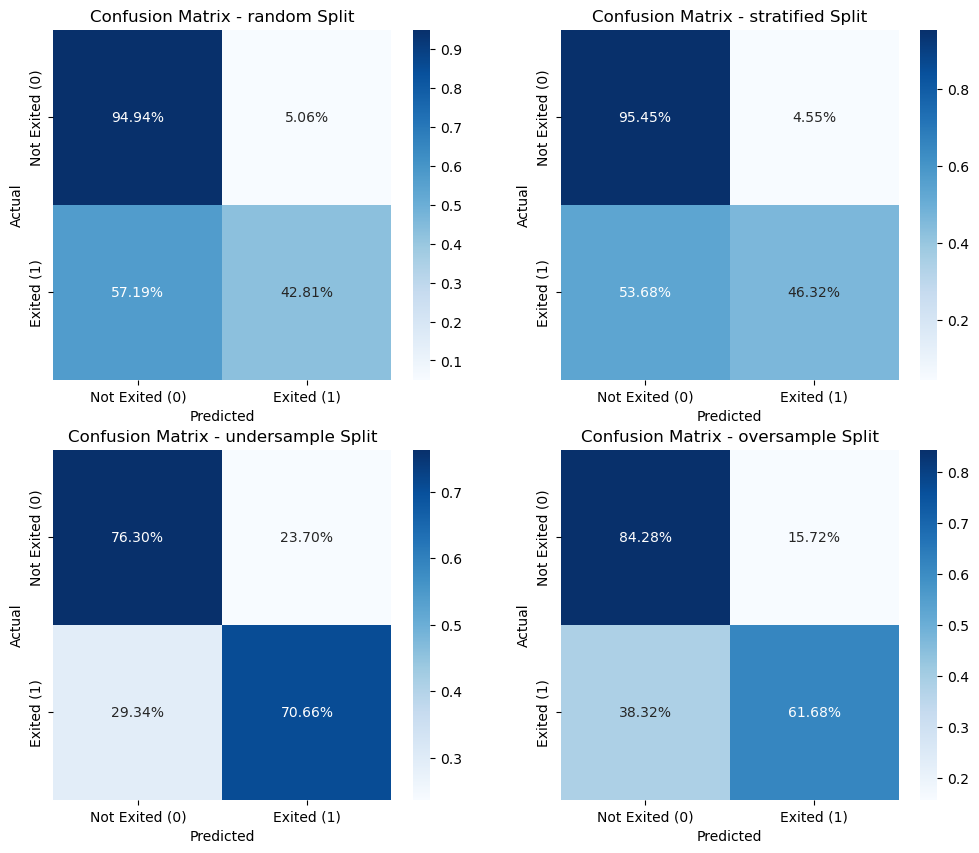

<Figure size 800x600 with 0 Axes>

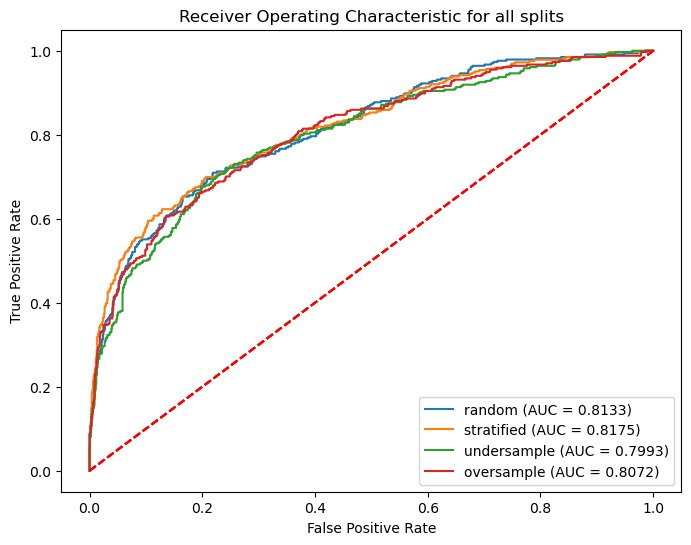

,test_precision_1,test_recall_1,test_f1_score_1,false_positives,false_negatives,balanced_accuracy
random,0.690821,0.428144,0.528651,64.0,191.0,0.688795
stratified,0.722488,0.463190,0.564486,58.0,175.0,0.708832
undersample,0.440299,0.706587,0.542529,300.0,98.0,0.734810
oversample,0.508642,0.616766,0.557510,199.0,128.0,0.729789


In [105]:
performance_reduced = {}
evaluating_performance_diff_splits(model=best_model,split_data = split_data,performance_matrix=performance_reduced)

performance_reduced_df = pd.DataFrame(performance_reduced).T
performance_reduced_df

This has again caused a decline in our model. We'll now try with the base model to see if this leads to an improvement.

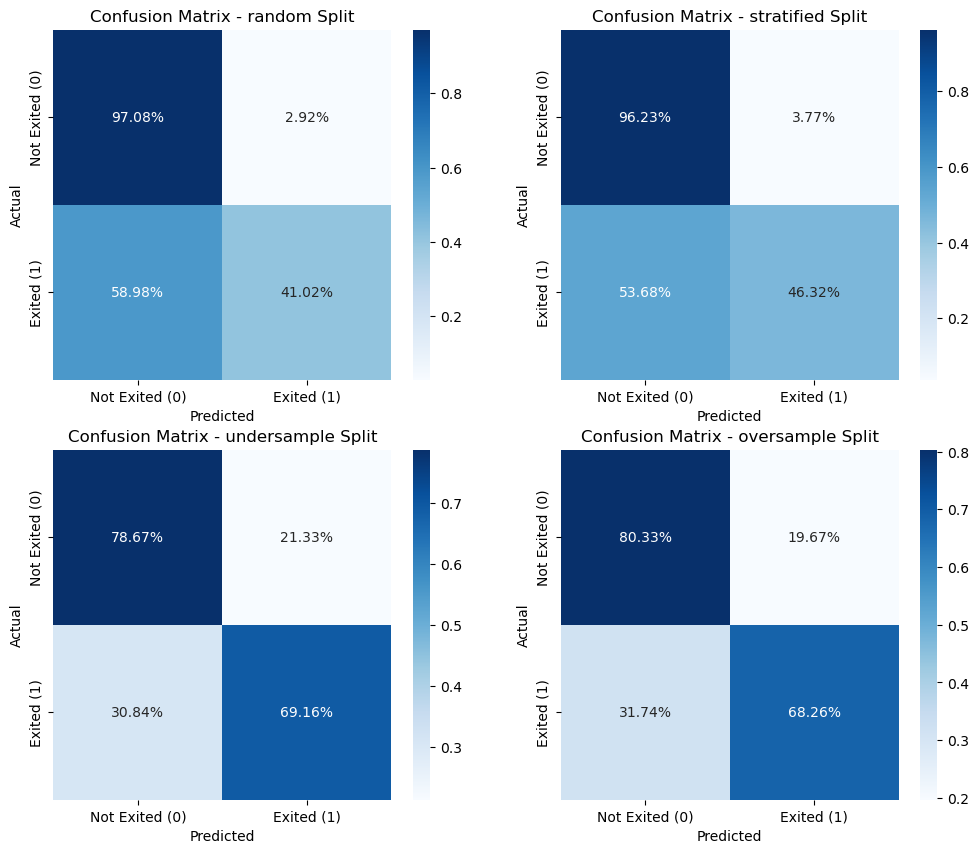

<Figure size 800x600 with 0 Axes>

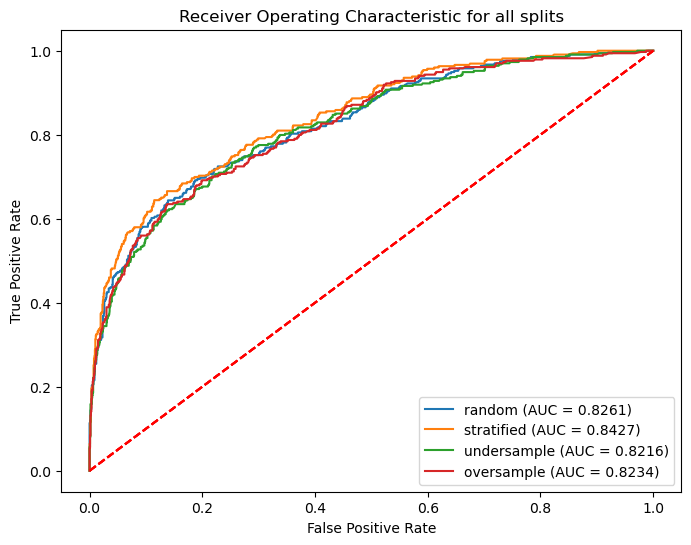

,test_precision_1,test_recall_1,test_f1_score_1,false_positives,false_negatives,balanced_accuracy
random,0.787356,0.410180,0.539370,37.0,197.0,0.690477
stratified,0.758794,0.463190,0.575238,48.0,175.0,0.712757
undersample,0.461078,0.691617,0.553293,270.0,103.0,0.739173
oversample,0.477987,0.682635,0.562269,249.0,106.0,0.742976


In [106]:
init_performance_reduced = {}
evaluating_performance_diff_splits(model=model,split_data = split_data,performance_matrix=init_performance_reduced)

init_performance_reduced_df = pd.DataFrame(init_performance_reduced).T
init_performance_reduced_df

This has improved our oversample recall but led to a decrease in the rest of the variables.